Opening ./results/result.p
Opening ./results/Result-June3-final.p
+------------+-------------+----------------+------------------+----------------+---------+----------+--------+
|   Total    | omp-offload | omp-offload-1d | omp-offload-bulk | omp-offload-at | omp-dce | dce-bulk | dce-at |
+------------+-------------+----------------+------------------+----------------+---------+----------+--------+
|  backprop  |    33.637   |     0.317      |      17.177      |     12.38      |  26.54  |  11.457  |  7.87  |
|   kmeans   |    40.587   |     35.983     |      42.97       |     38.173     |  41.297 |  42.93   |  38.0  |
|  myocyte   |    22.453   |      2.44      |      10.207      |      3.13      |  20.153 |  6.563   | 2.977  |
| pathfinder |    27.543   |     24.473     |      26.117      |     26.467     |  27.55  |  26.78   | 26.427 |
+------------+-------------+----------------+------------------+----------------+---------+----------+--------+


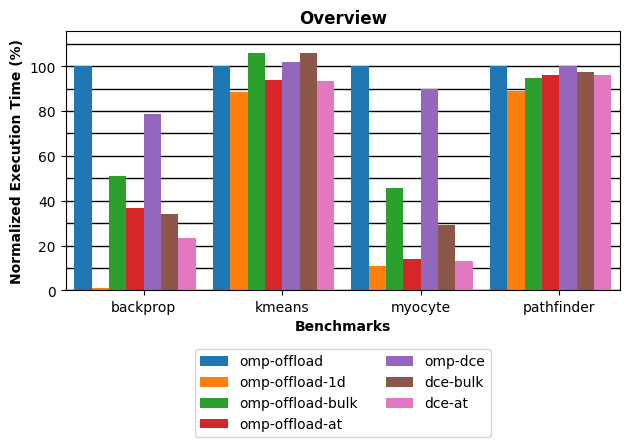

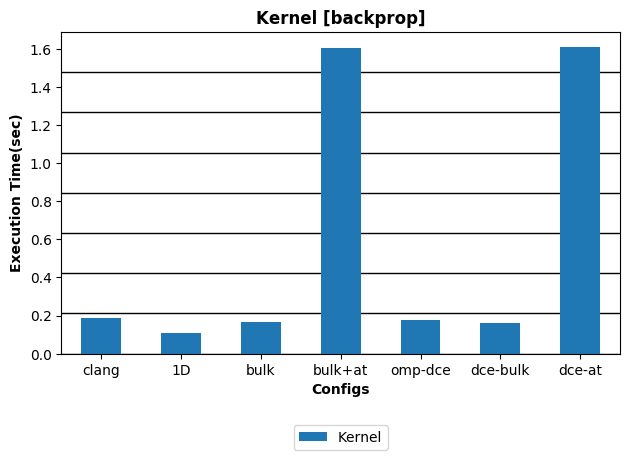

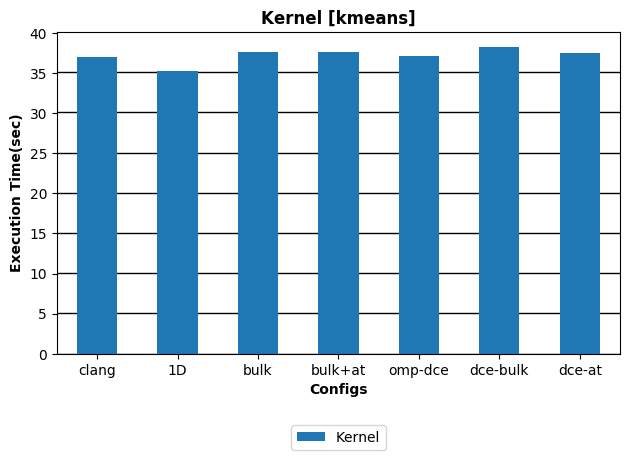

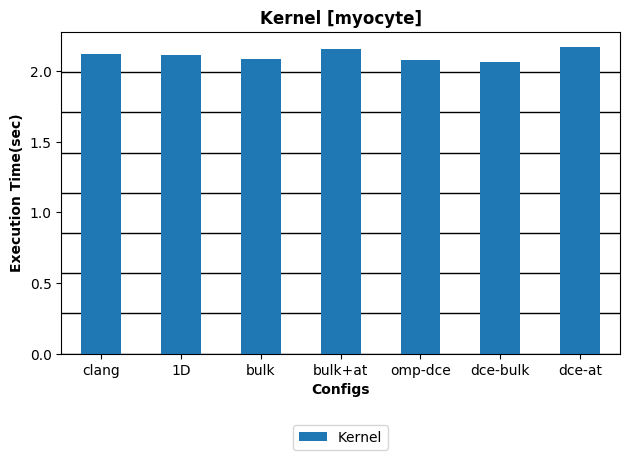

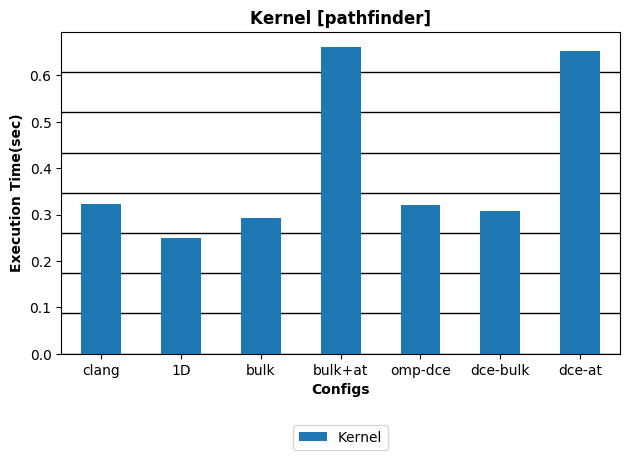

<Figure size 640x480 with 0 Axes>

In [36]:
#!/usr/bin/env python3

import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axs
from prettytable import PrettyTable
from operator import add

from dataTy import dataTy
from dataTy import Output
from dataTy import ResultHelper

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))
def Round(F):
    return round(F,3)
def open_pickle(default_name):
    pfile = default_name
    # Use this in terminal py
    #if len(sys.argv) > 1:
        # first arg is filename
    #    pfile = sys.argv[1]
    print("Opening " + pfile)
    with open(pfile,'rb') as f:
        result = pickle.load(f)
    return result
def PrettyTableGen(lists):
    PT = PrettyTable()
    PT.field_names = lists[0]
    for li in lists[1:]:
        PT.add_row(li)
    return PT
    
class Summarizer:
    def __init__(self, result):
        lists = []
        lists.append(["Total"] + [ config for config in ResultHelper.getConfigs(result)])
        for proj in ResultHelper.getProjs(result):
            row = [proj]
            for config in ResultHelper.getConfigs(result):
                avg_time = Round(result[config][proj].time)
                row.append(avg_time)
            lists.append(row)
        print(PrettyTableGen(lists))
        
class Printer:
    def __init__(self, result, the_config = None, the_proj = None):
        if the_config == None :
             configs = result.keys()
        else:
            configs = [the_config]
        for config in configs:
            output_of_proj = result[config]
            if the_proj == None:
                projs = output_of_proj.keys()
            else:
                projs = [the_proj]
                    
            for proj in projs:
                # Print with PrettyTable
                output = output_of_proj[proj]
                PT = PrettyTable()
                T = ResultHelper.getErrorOrAvgTime(output)
                PT.title = "" + config + " " + proj + " " + str(Round(T))
                PT.field_names = ["Attr", "Time", "Count"]
                PT.align["Attr"] = "l"
                PT.add_row(["Total", Round(output.prof_time), ""])
                for name in output.prof_data:
                    d = output.prof_data[name]
                    PT.add_row([name, Round(d.Value), d.Count])
                print(PT)
class config:
    width = 1
    margin = 1
    left_margin = 1
    def rename_config(config):
        renametable = {"omp-offload" : "clang", "omp-offload-1d" : "1D", "omp-offload-bulk": "bulk", "omp-offload-at": "bulk+at"}
        ret = renametable.get(config)
        if ret == None:
            return config
        else:
            return ret
    save_img = True

class PlotPrinter:
    def submit(name):
        # Make layout clear
        plt.tight_layout()
        
        # Add hlines
        [ymin, ymax] = plt.gca().get_ylim()
        if ymax > 100:
            step = 10
        else:
            step = (ymax - ymin)/ 8
        
        ylist = np.arange(0, ymax, step)
        [xmin, xmax] = plt.gca().get_xlim()
        plt.hlines(ylist, xmin, xmax, zorder=0, linewidth=1)
        
        if config.save_img:
            plt.savefig("plot/" + name + ".png", format='png',dpi=300, edgecolor='k')
        else:
            plt.show()
        plt.clf()

class ColumnChartPrinter:
    def plot(result, norm=False):
        # Get projs
        projs = ResultHelper.getProjs(result)
        configs = ResultHelper.getConfigs(result)
        proj_count = len(projs)
        config_count = len(configs)
        if ResultHelper.invalid(result) :
            return
        n = 0
        xpos_base = np.arange(0, proj_count * (config_count + 1), config_count + 1)
        last_col = xpos_base[-1]
        
        factors =  ResultHelper.getNormFactors(result, ["Times"], norm)
        for c in configs:
            # prepare data
            height = []
            xpos = [x + config.width * n for x in xpos_base]
            for p in projs:
                time = result[c][p].prof_data["Times"].Value * factors[p]
                height.append(time)
            plt.bar(xpos, height, width=config.width, label=c)
            last_col = xpos[-1]
            n += 1
        if norm == True:
            plt.ylabel('Normalized Execution Time (%)', fontweight='bold')
        else:
            plt.ylabel('Execution Time(sec)', fontweight='bold')
        
        plt.xlabel('Benchmarks', fontweight='bold')
        plt.title('Overview', fontweight='bold')
        # Insert in the center
        xticks = [x + config_count / 2 * config.width for x in xpos_base]
        plt.xticks(xticks, projs)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
        plt.xlim(xpos_base[0] - config.left_margin, last_col + config.margin)
        PlotPrinter.submit("all")

class KernelTimePrinter:
    def plotStackChar(result, configs, proj, ind, metrics):
        N = len(configs)
        btn = [0] * N
        plist = []
        for m in metrics:
            time = []
            for c in configs:
                time.append(float(result[c][proj].prof_data[m].Value))
            p = plt.bar(ind, time, config.width, bottom=btn)
            plist.append(p)
            # Increase btn
            btn = list(map(add, btn, time))
        return plist

    def plot(result, proj, norm=False):
        configs = ResultHelper.getConfigs(result)
        metrics = ["Kernel"]
        #metrics = ["H2DTransfer", "D2HTransfer", "UpdatePtr"]
        #metrics = ["OMPRuntime", "Kernel", "H2DTransfer", "D2HTransfer", "UpdatePtr"]
        
        config_count = len(configs)
        ind = np.arange(0, config_count * (config.width + 1),  config.width + 1)
        #ind = np.arange(N)    # the x locations for the groups

        plist = StackChartPrinter.plotStackChar(result, configs, proj, ind, metrics)

        plt.ylabel('Execution Time(sec)', fontweight='bold')
        plt.xlabel('Configs', fontweight='bold')
        plt.title('Kernel [' + proj + ']', fontweight='bold')
        plt.xticks(ind, [config.rename_config(x) for x in configs]) #plt.yticks(np.arange(0, 81, 10))
        plt.legend(plist, metrics, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
        plt.xlim(ind[0]- config.left_margin, ind[-1] + config.margin)
        PlotPrinter.submit(proj)
            
class StackChartPrinter:
    def plotStackChar(result, configs, proj, ind, metrics):
        N = len(configs)
        btn = [0] * N
        plist = []
        for m in metrics:
            time = []
            for c in configs:
                time.append(float(result[c][proj].prof_data[m].Value))
            p = plt.bar(ind, time, config.width, bottom=btn)
            plist.append(p)
            # Increase btn
            btn = list(map(add, btn, time))
        return plist

    def plot(result, proj, norm=False):
        configs = ResultHelper.getConfigs(result)
        metrics = ["Other","OMPRuntime", "Kernel", "H2DTransfer", "D2HTransfer", "UpdatePtr"]
        #metrics = ["OMPRuntime", "Kernel", "H2DTransfer", "D2HTransfer", "UpdatePtr"]
        
        config_count = len(configs)
        ind = np.arange(0, config_count * (config.width + 1),  config.width + 1)
        #ind = np.arange(N)    # the x locations for the groups

        plist = StackChartPrinter.plotStackChar(result, configs, proj, ind, metrics)

        plt.ylabel('Execution Time(sec)', fontweight='bold')
        plt.xlabel('Configs', fontweight='bold')
        plt.title('[Breakdown] ' + proj, fontweight='bold')
        plt.xticks(ind, [config.rename_config(x) for x in configs]) #plt.yticks(np.arange(0, 81, 10))
        plt.legend(plist, metrics, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
        plt.xlim(ind[0]- config.left_margin, ind[-1] + config.margin)
        PlotPrinter.submit(proj)

class OffloadVS1DNormPrinter:
    # Like stackChart
    def plot(result):
        projs = ResultHelper.getProjs(result)
        configs = ["omp-offload", "omp-offload-1d"]
        metrics = ["OMPRuntime", "Kernel", "H2DTransfer", "D2HTransfer", "UpdatePtr"]
        for c in configs:
            if result.get(c) == None:
                print(c + " key not found")
                return
        # Gen xpos and xticks
        xpos = []
        xticks = []
        ind = np.arange(0, 2 * (config.width + 0.5), config.width + 0.5).tolist() # the x locations for the groups
        for proj in projs:
            xpos = xpos + ind
            xticks += [proj, proj+"1d"]
            ind = [x + 2 * config.width + 2.5 * config.width for x in ind]

        btn = [0] * len(projs) * 2
        plist = []
        # calculate the factor
        factors =  ResultHelper.getNormFactors(result, metrics, True)
                
        for m in metrics:
            time = []
            for proj in projs:
                f = factors[proj]
                for c in configs:
                    time.append(f*float(result[c][proj].prof_data[m].Value))
                    
            plist.append(plt.bar(xpos, time, config.width, bottom=btn))
            btn = list(map(add, btn, time))
        plt.ylabel('Execution Time(%)', fontweight='bold')
        plt.ylabel('Normalized Execution Time (%)', fontweight='bold')
        #plt.xlabel('Configs', fontweight='bold')
        plt.title("Direct Offload vs 1D Refactor Comparison", fontweight='bold')
        # shift because of rotation
        plt.xticks([x - config.width/2 for x in xpos], xticks, rotation=40)
        plt.legend(plist, metrics, loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)
        plt.xlim(xpos[0] - config.left_margin, xpos[-1] + config.margin)
        PlotPrinter.submit("Offloadvs1DCompare")

class ATOptPrinter:
    def plot(results):
        for r in results:
            first = results[r]
            break
        opts = results.keys()
        
        projs = ResultHelper.getProjs(first)
        the_config = "omp-offload-at"
        #metrics = [ "Kernel"]
        metrics = ["OMPRuntime", "Kernel", "H2DTransfer", "D2HTransfer", "UpdatePtr"]
        
        # Gen xpos and xticks
        xpos = []
        xticks = []
        ind = np.arange(0, 2 * (config.width + 0.5), config.width + 0.5).tolist() # the x locations for the groups
        for proj in projs:
            xpos = xpos + ind
            xticks += [proj, proj+"-opt"]
            ind = [x + 2 * config.width + 2.5 * config.width for x in ind]

        btn = [0] * len(projs) * 2
        plist = []
        # calculate the factor
        factors = {}
        for proj in projs:
            sum = 0
            for m in metrics:
                sum += float(first[the_config][proj].prof_data[m].Value)
            factors[proj] = 100/sum
                
        for m in metrics:
            time = []
            for proj in projs:
                f = factors[proj]
                for o in opts:
                    time.append(f*float(results[o][the_config][proj].prof_data[m].Value))
                    
            plist.append(plt.bar(xpos, time, config.width, bottom=btn))
            btn = list(map(add, btn, time))
        plt.ylabel('Execution Time(%)', fontweight='bold')
        plt.title("AT Opt Comparison", fontweight='bold')
        # shift because of rotation
        plt.xticks([x - config.width/2 for x in xpos], xticks, rotation=40)
        plt.legend(plist, metrics, loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)
        plt.xlim(xpos[0] - config.left_margin, xpos[-1] + config.margin)
        #plt.ylim(top=110)
        PlotPrinter.submit("ATOptEffect")
        
# Compare different at optimization
def at_opt():
    files = {}
    files["O0"]   = "./results/at-O0.p"
    files["Osm"]  = "./results/at-Osm.p"
    
    results = {}
    for f in files:
        results[f] = pickle.load(open(files[f], "rb"))
        print("Open "+ files[f])
        ResultHelper.preprocessing(results[f])
    ATOptPrinter.plot(results)
    
def main():
    # Read from pickle
    result = open_pickle("./results/result.p")
    result = open_pickle("./results/Result-June3-final.p")
    ResultHelper.preprocessing(result)
    Summarizer(result)
    #return
    #Printer(result)
    #for config in result:
        #for proj in result[config]:
   
    ColumnChartPrinter.plot(result,True)
    #OffloadVS1DNormPrinter.plot(result) 
    for p in ResultHelper.getProjs(result):
        KernelTimePrinter.plot(result,p)
        #StackChartPrinter.plot(result, p)
        pass
        

plt.rcParams['figure.dpi'] = 80
config.save_img = False
#plt.style.use('seaborn-deep') # choose style https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default')
if __name__ == "__main__":
    main()
    #at_opt()
    
# FIXME color of dec to be alike
    

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate

def TableGen(result, proj):
    colLabels = ["[{0}]".format(proj)]
    rowLabelsDict = {}
    index = 0
    for config in result:
        colLabels.append(config)
        output = result[config][proj].prof_data
        for attr in output:
            attr_count = attr + "_count"
            # init attr
            if rowLabelsDict.get(attr) == None:
                rowLabelsDict[attr] = [attr]
                rowLabelsDict[attr_count] = ["-"]
            CountDiff = index - len(rowLabelsDict[attr])
            for i in range(CountDiff):
                print("Append lost")
                rowLabelsDict[attr].append("NaN")
                rowLabelsDict[attr_count].append("NaN")
            rowLabelsDict[attr].append(output[attr].Value)
            rowLabelsDict[attr_count].append(output[attr].Count)
        index = index + 1
    # Merge data to list
    clust_data = []
 
    for entry in rowLabelsDict:
        clust_data.append(rowLabelsDict[entry])
    
    #StackChartPrinter.plot(result, proj)
    display(HTML("<style>table, th, td {font-size: 15px}</style>" + tabulate.tabulate(clust_data, colLabels, tablefmt='html')))

def main():
    # Data
    result = open_pickle("./results/result.p")
    result = open_pickle("./results/Result-June3-final.p")
    ResultHelper.preprocessing(result)
    TableGen(result, "backprop")

main()


In [ ]:
# Get speedup data
def PrintFinalSpeedUp(result):
    baseline_config = "omp-offload"
    final_config = "dce-at"
    # ------------------------------------------------------------------------
    at_ratios = []
    lists = []
    lists.append(["Total"] + [ c for c in result])
    
    for c in result:
        projs = result[c].keys()
        break
    for p in projs:
        
        baseline = result[baseline_config][p].time
        li = [p, 1]
        for c in result:
            if c == baseline_config:
                continue
            v = result[c][p].time
            ratio = ( baseline) / v
            li.append(Round(ratio))
            if c == final_config:
                at_ratios.append(ratio)
        lists.append(li)
    print(PrettyTableGen(lists))
    print(Round(geo_mean(at_ratios)))
    # ----------------------------------------------------------------------
    at_ratios = []
    lists = []
    lists.append(["Kernel"] + [ c for c in result])
    
    for c in result:
        projs = result[c].keys()
        break
    for p in projs:
        
        baseline = result[baseline_config][p].prof_data["Kernel"].Value
        li = [p, 1]
        for c in result:
            if c == baseline_config:
                continue
            v = result[c][p].prof_data["Kernel"].Value
            ratio = ( baseline ) / v
            li.append(Round(ratio))
            if c == final_config:
                at_ratios.append(ratio)
        lists.append(li)
    print(PrettyTableGen(lists))
    print(Round(geo_mean(at_ratios)))
    # ----------------------------------------------------------------------
    at_ratios = []
    lists = []
    lists.append(["Data Movement"] + [ c for c in result])
    for c in result:
        projs = result[c].keys()
        break
    for p in projs:
        metrics = ["H2DTransfer", "D2HTransfer", "UpdatePtr"]
        
        baseline = 0
        for m in metrics:
            baseline += result[baseline_config][p].prof_data[m].Value
        li = [p, 1]
        for c in result:
            if c == baseline_config:
                continue
            v = 0
            for m in metrics:
                v += result[c][p].prof_data[m].Value
            ratio = ( baseline) / v
            li.append(Round(ratio))
            if c == final_config:
                at_ratios.append(ratio)
        lists.append(li)
    print(PrettyTableGen(lists))
    print(Round(geo_mean(at_ratios)))

def main():
    # Data
    result = open_pickle("./results/Result-June3-final.p")
    ResultHelper.preprocessing(result)
    
    Summarizer(result)
    PrintFinalSpeedUp(result)
    

main()